In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas
import os
import zipfile
import requests
import tqdm
from sklearn import dummy, metrics, cross_validation, ensemble

import keras.models as kmodels
import keras.layers as klayers
import keras.backend as K
import keras

Using TensorFlow backend.


In [3]:
# Download the dataset. It's small, only about 6 MB.
if not os.path.exists('./ml-1m'):
    url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
    response = requests.get(url, stream=True)
    total_length = response.headers.get('content-length')
    bar = tqdm.tqdm_notebook(total=int(total_length))
    with open('./ml-1m.zip', 'wb') as f:
        for data in response.iter_content(chunk_size=4096):
            f.write(data)
            bar.update(4096)
    zip_ref = zipfile.ZipFile('./ml-1m.zip', 'r')
    zip_ref.extractall('.')
    zip_ref.close()

In [4]:
# Read in the dataset, and do a little preprocessing,
# mostly to set the column datatypes.
users = pandas.read_csv('./ml-1m/users.dat', sep='::', 
                        engine='python', 
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pandas.read_csv('./ml-1m/ratings.dat', engine='python', 
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies = pandas.read_csv('./ml-1m/movies.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre']).set_index('movieid')
movies['genre'] = movies.genre.str.split('|')

users.age = users.age.astype('category')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('category')
ratings.userid = ratings.userid.astype('category')

In [5]:
# Count the movies and users
n_movies = movies.shape[0]
n_users = users.shape[0]

# Also, make vectors of all the movie ids and user ids. These are
# pandas categorical data, so they range from 1 to n_movies and 1 to n_users, respectively.
movieid = ratings.movieid.cat.codes.values
userid = ratings.userid.cat.codes.values

In [6]:
# And finally, set up a y variable with the rating,
# as a one-hot encoded matrix.
#
# note the '- 1' for the rating. That's because ratings
# go from 1 to 5, while the matrix columns go from 0 to 4

y = np.zeros((ratings.shape[0], 5))
y[np.arange(ratings.shape[0]), ratings.rating - 1] = 1

In [7]:
# Dummy classifier! Just see how well stupid can do.
pred = dummy.DummyClassifier(strategy='prior')
pred.fit(ratings[['userid', 'movieid']], ratings.rating)

print(metrics.mean_absolute_error(ratings.rating, pred.predict(ratings[['userid', 'movieid']])))

0.870960969157


In [19]:
# Now, the deep learning classifier

# First, we take the movie and vectorize it.
# The embedding layer is normally used for sequences (think, sequences of words)
# so we need to flatten it out.
# The dropout layer is also important in preventing overfitting
movie_input = keras.layers.Input(shape=[1])
movie_vec = keras.layers.Flatten()(keras.layers.Embedding(n_movies + 1, 32)(movie_input))
movie_vec = keras.layers.Dropout(0.5)(movie_vec)

# Same thing for the users
user_input = keras.layers.Input(shape=[1])
user_vec = keras.layers.Flatten()(keras.layers.Embedding(n_users + 1, 32)(user_input))
user_vec = keras.layers.Dropout(0.5)(user_vec)

# Next, we join them all together and put them
# through a pretty standard deep learning architecture
input_vecs = keras.layers.merge([movie_vec, user_vec], mode='concat')
nn = keras.layers.Dropout(0.5)(keras.layers.Dense(128, activation='relu')(input_vecs))
nn = keras.layers.normalization.BatchNormalization()(nn)
nn = keras.layers.Dropout(0.5)(keras.layers.Dense(128, activation='relu')(nn))
nn = keras.layers.normalization.BatchNormalization()(nn)
nn = keras.layers.Dense(128, activation='relu')(nn)

# Finally, we pull out the result!
result = keras.layers.Dense(5, activation='softmax')(nn)

# And make a model from it that we can actually run.
model = kmodels.Model([movie_input, user_input], result)
model.compile('adam', 'categorical_crossentropy')

# If we wanted to inspect part of the model, for example, to look
# at the movie vectors, here's how to do it. You don't need to 
# compile these models unless you're going to train them.
final_layer = kmodels.Model([movie_input, user_input], nn)
movie_vec = kmodels.Model(movie_input, movie_vec)

In [20]:
# Split the data into train and test sets...
a_movieid, b_movieid, a_userid, b_userid, a_y, b_y = cross_validation.train_test_split(movieid, userid, y)

In [21]:
# And of _course_ we need to make sure we're improving, so we find the MAE before
# training at all.
metrics.mean_absolute_error(np.argmax(b_y, 1)+1, np.argmax(model.predict([b_movieid, b_userid]), 1)+1)

1.9733136575046091

Train on 750156 samples, validate on 250053 samples
Epoch 1/20
750156/750156 [==============================] - 302s - loss: 1.3333 - val_loss: 1.2478
Epoch 2/20
750156/750156 [==============================] - 323s - loss: 1.2639 - val_loss: 1.2287
Epoch 3/20
750156/750156 [==============================] - 327s - loss: 1.2508 - val_loss: 1.2257
Epoch 4/20
750156/750156 [==============================] - 293s - loss: 1.2434 - val_loss: 1.2222
Epoch 5/20
750156/750156 [==============================] - 316s - loss: 1.2402 - val_loss: 1.2173
Epoch 6/20
750156/750156 [==============================] - 301s - loss: 1.2366 - val_loss: 1.2159
Epoch 7/20
750156/750156 [==============================] - 314s - loss: 1.2334 - val_loss: 1.2150
Epoch 8/20
750156/750156 [==============================] - 322s - loss: 1.2324 - val_loss: 1.2153
Epoch 9/20
750156/750156 [==============================] - 313s - loss: 1.2303 - val_loss: 1.2139
Epoch 10/20
750156/750156 [==============================

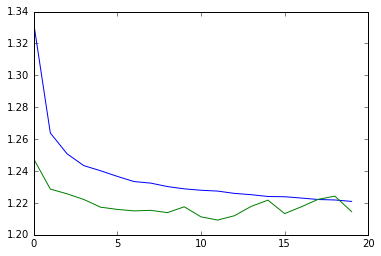

In [22]:
try:
    history = model.fit([a_movieid, a_userid], a_y, 
                         nb_epoch=20, 
                         validation_data=([b_movieid, b_userid], b_y))
    plot(history.history['loss'])
    plot(history.history['val_loss'])
except KeyboardInterrupt:
    pass

In [23]:
# This is the number that matters. It's the held out 
# test set score. Note the + 1, because np.argmax will
# go from 0 to 4, while our ratings go 1 to 5.
metrics.mean_absolute_error(
    np.argmax(b_y, 1)+1, 
    np.argmax(model.predict([b_movieid, b_userid]), 1)+1)

0.67782430124813542

In [24]:
# For comparison's sake, here's the score on the training set.
metrics.mean_absolute_error(
    np.argmax(a_y, 1)+1, 
    np.argmax(model.predict([a_movieid, a_userid]), 1)+1)

0.65481579831395065